# ARMA task

## Run this to install the required packages

In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [1]:
import json
import pandas as pd
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.api as sm
import numpy as np
import warnings
from utils import read_datasets, get_score, plot_anomalies


warnings.filterwarnings("ignore")

## Functions used for ARMA task

### Finds the best prder (p and q) bases on autocorrelation and partial autocorrelation functions

In [2]:
def find_order(data, terms):
    """
    Find the best p and q orders for ARMA based on acf and pacf values
    :param data: dataset
    :param terms: Specify if p or q need to be found
    :return: tuned order
    """
    # specify whether p or q need to be found
    if terms == "AR":
        lag = pacf(data, nlags=20, method='ols')
    elif terms == "MA":
        lag = acf(data, nlags=20)
    # define upper confidence interval as the one
    # of Normal distribution N(0, 1/len(data))
    thres = 1.96 / np.sqrt(len(data))
    for i, val in enumerate(lag):
        if val < thres:
            break
    return i - 1

### Finds the best prder (p and q) bases on AIC

In [3]:
def tune_arma():
    """
    Finds the best order for all sensors and save th ein a json file.
    """
    # read dataset
    scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()

    # coluns to drop, status signals
    drop_columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11',
                    'S_V2']

    # drop columns on all the 3 datasets
    train_data1 = scaled_df1.drop(drop_columns, axis=1)
    train_data2 = scaled_df2.drop(drop_columns, axis=1)

    # name of the sensors we use
    # sensors = train_data1.columns.values
    sensors = ['P_J280', 'F_PU3', 'F_V2', 'P_J300', 'P_J289', 'L_T6', 'F_PU10']

    results = {}
    for sensor in sensors:
        print('---------- {} ----------'.format(sensor))
        train_ts = pd.Series(train_data1[sensor], index=train_data1.index, )
        train_2_ts = pd.Series(train_data2[sensor], index=train_data2.index, )

        # find the orders from acf and pacf
        p = find_order(train_ts, terms='AR')
        q = find_order(train_ts, terms='MA')
        if p == 0 or q == 0:
            p, q = 1, 1
        try:
            # find order by aic criterion, with thresholds for p and q defined by pacf and acf
            res = sm.tsa.arma_order_select_ic(train_2_ts, ic=['aic'], max_ar=p, max_ma=q)
            order = res.aic_min_order
            order = list(order)
            if order[0] == 0 or order[1] == 0:
                order[0] = 1
                order[1] = 1
            order = tuple(order)
            results[sensor] = order
        except (np.linalg.LinAlgError, IndexError):
            if p == 0 or q == 0:
                p, q = 1, 1
            order = (p, q)
            results[sensor] = order
        print("p={1} and q={2}".format(sensor, order[0], order[1]))
    results = {k: [int(v[0]), int(v[1])] for k, v in results.items()}
    with open("best_order.json", "w") as f:
        json.dump(results, f)
    print(results)

In [4]:
tune_arma()

---------- P_J280 ----------
p=1 and q=9
---------- F_PU3 ----------
p=1 and q=1
---------- F_V2 ----------
p=1 and q=5
---------- P_J300 ----------
p=1 and q=4
---------- P_J289 ----------
p=1 and q=4
---------- L_T6 ----------
p=1 and q=1
---------- F_PU10 ----------
p=1 and q=1
{'P_J280': [1, 9], 'F_PU3': [1, 1], 'F_V2': [1, 5], 'P_J300': [1, 4], 'P_J289': [1, 4], 'L_T6': [1, 1], 'F_PU10': [1, 1]}


# ARMA task implementation 

## Read datasets, drop state columns, select sensors and load best ARMA orders

In [5]:
# read datasets
scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()



# coluns to drop, status signals
drop_columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11',
                'S_V2']

# drop columns on all the 3 datasets
arma_train_data1 = scaled_df1.drop(drop_columns, axis=1)
arma_train_data2 = scaled_df2.drop(drop_columns, axis=1)
arma_test_data = scaled_test_df.drop(drop_columns, axis=1)

# selected sensor names
# sensors = arma_train_data1.columns.values
sensors = ['P_J280', 'F_PU3', 'F_V2', 'P_J300', 'P_J289', 'L_T6', 'F_PU10']

# get the best p and q as decided by tune_arma.py
with open("best_order.json", "r") as f:
    best_orders = json.load(f)

## Run ARMA for alls sensors

---------- P_J280 ----------
TP: 0, FP: 0, TPR: 0.0, TNR: 1.0
Sttd: 0.0, Scm: 0.5, S: 0.25
---------- F_PU3 ----------
TP: 60, FP: 0, TPR: 0.14742014742014742, TNR: 1.0
Sttd: 0.2857142857142857, Scm: 0.5737100737100738, S: 0.42971217971217973
---------- F_V2 ----------
TP: 4, FP: 4, TPR: 0.009828009828009828, TNR: 0.9976218787158145
Sttd: 0.37383146807109935, Scm: 0.5037249442719122, S: 0.43877820617150576
---------- P_J300 ----------
TP: 19, FP: 8, TPR: 0.04668304668304668, TNR: 0.995243757431629
Sttd: 0.21637362637362645, Scm: 0.5209634020573378, S: 0.36866851421548213
---------- P_J289 ----------
TP: 19, FP: 8, TPR: 0.04668304668304668, TNR: 0.995243757431629
Sttd: 0.21637362637362645, Scm: 0.5209634020573378, S: 0.36866851421548213
---------- L_T6 ----------
TP: 0, FP: 0, TPR: 0.0, TNR: 1.0
Sttd: 0.0, Scm: 0.5, S: 0.25
---------- F_PU10 ----------
TP: 0, FP: 0, TPR: 0.0, TNR: 1.0
Sttd: 0.0, Scm: 0.5, S: 0.25


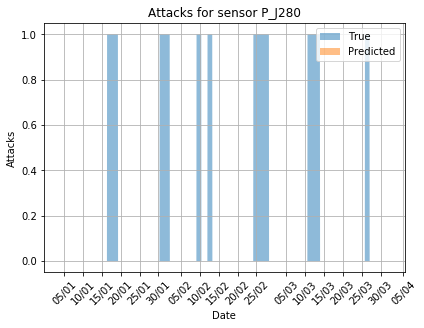

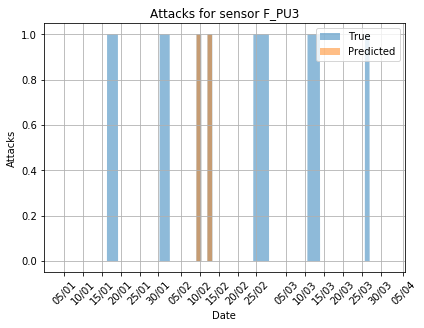

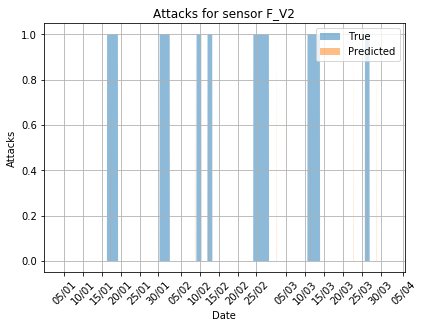

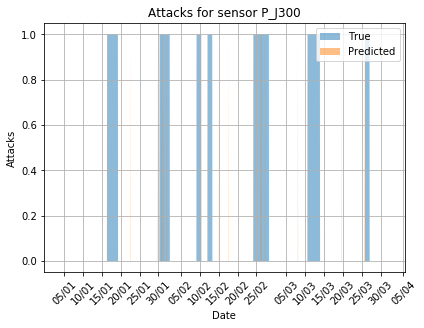

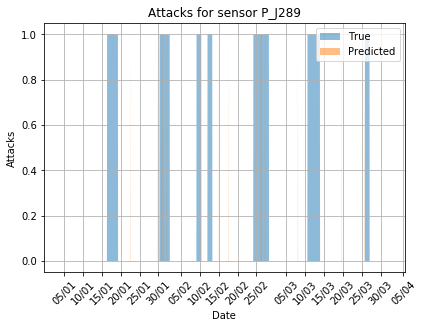

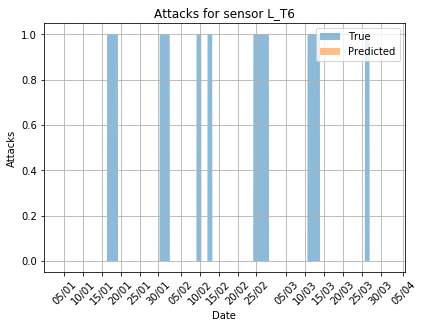

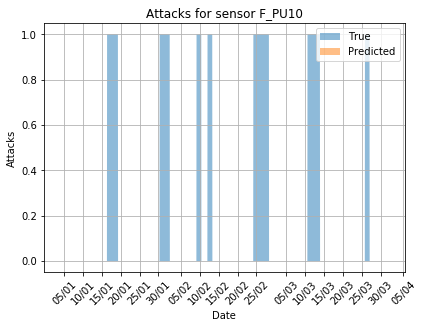

In [9]:
all_predictions_dict = {}

# initialize total anomalies (for all the selected sensors) to 0
total_anomalies = pd.Series(
    [0 for _ in range(len(pd.Series(scaled_test_df["L_T2"], index=scaled_test_df.index, )))],
    index=scaled_test_df.index, )

for sensor in sensors:
    # get p and q
    p = best_orders[sensor][0]
    q = best_orders[sensor][1]

    # get data in time series for the specific sensor
    train_ts = pd.Series(arma_train_data1[sensor], index=arma_train_data1.index, dtype=np.float)
    train_2_ts = pd.Series(arma_train_data2[sensor], index=arma_train_data2.index, dtype=np.float)
    test_ts = pd.Series(arma_test_data[sensor], index=arma_test_data.index, dtype=np.float)

    # fit arma on training dataset 1,
    # note that ARIMAX with order order=(p, 0, q) is equal to ARMA
    model = sm.tsa.SARIMAX(train_ts, order=(p, 0, q))  # 5,7 is decided using arma_order_select_ic method
    model_fit = model.fit(start_params=[0 for i in range(q + 1)] + [1], disp=False)

    # use training dataset 2 to find the threshold value
    start = train_2_ts.index[0]
    predict = pd.Series()
    # make predicition for training dataset 2
    # rrediction for an ARMA process with known coefficient is just a filtering problem
    for t in train_2_ts.index:
        model2 = sm.tsa.SARIMAX(train_2_ts[start:t], order=(p, 0, q))
        model_fit2 = model2.filter(model_fit.params)
        predict = predict.append(model_fit2.forecast(1))

    # find residuals
    resids2 = np.subtract(train_2_ts, predict)
    resids2 = np.abs(resids2)
    # resids2 = np.abs(resids2 - np.mean(resids2)) / np.std(resids2)

    # keep the max residual from the anomalies in the dataset
    anomaly_residuals = [x for i, x in enumerate(resids2) if train_y2[i] == 1]
    if anomaly_residuals:
        threshold = np.max(np.abs(anomaly_residuals))
    else:
        threshold = np.max(np.abs(model_fit.resid))

    # test on test data
    start = test_ts.index[0]
    predict = pd.Series()
    for t in test_ts.index:
        model2 = sm.tsa.SARIMAX(test_ts[start:t], order=(p, 0, q))
        model_fit2 = model2.filter(model_fit.params)
        predict = predict.append(model_fit2.forecast(1))
    # find residuals for test data
    res = np.subtract(test_ts, predict)
    res = np.abs(res)
    # res = np.abs(res - np.mean(res)) / np.std(res)

    # get predictions according to the threshold
    all_predictions = pd.Series([1 if x > threshold else 0 for i, x in enumerate(res)], index=scaled_test_df.index)
    
    # find indices of anomalies
    predicted_anomalies = np.where(all_predictions > 0)[0]
    true_anomalies = np.where(y > 0)[0]
    
    # get score
    [tp, fp, fn, tn, tpr, tnr, Sttd, Scm, S] = get_score(predicted_anomalies, true_anomalies, y=y)
    print('---------- {} ----------'.format(sensor))
    print("TP: {0}, FP: {1}, TPR: {2}, TNR: {3}".format(tp, fp, tpr, tnr))
    print("Sttd: {0}, Scm: {1}, S: {2}".format(Sttd, Scm, S))
    
    # plot residual for the selected sensor
    plot_anomalies(y, all_predictions, sensor, 'arma')
    
    total_anomalies = total_anomalies | all_predictions



## Plot attacks detected and achieved scores

TP: 82, FP: 12, TPR: 0.20147420147420148, TNR: 0.9928656361474435
Sttd: 0.7745368916797488, Scm: 0.5971699188108225, S: 0.6858534052452856


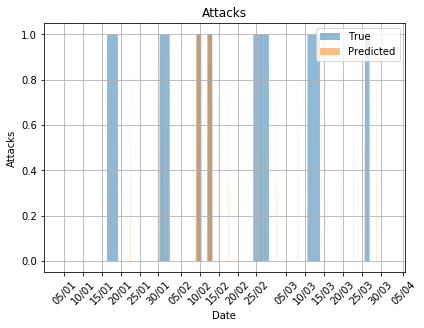

In [10]:
# plot all anomalies
plot_anomalies(y, total_anomalies, method='arma')
# find indices of anomalies
predicted_anomalies = np.where(total_anomalies == 1)[0]
true_anomalies = np.where(y == 1)[0]
# get score
[tp, fp, fn, tn, tpr, tnr, Sttd, Scm, S] = get_score(predicted_anomalies, true_anomalies, y=y)
print("TP: {0}, FP: {1}, TPR: {2}, TNR: {3}".format(tp, fp, tpr, tnr))
print("Sttd: {0}, Scm: {1}, S: {2}".format(Sttd, Scm, S))